<IPython.core.display.Javascript object>


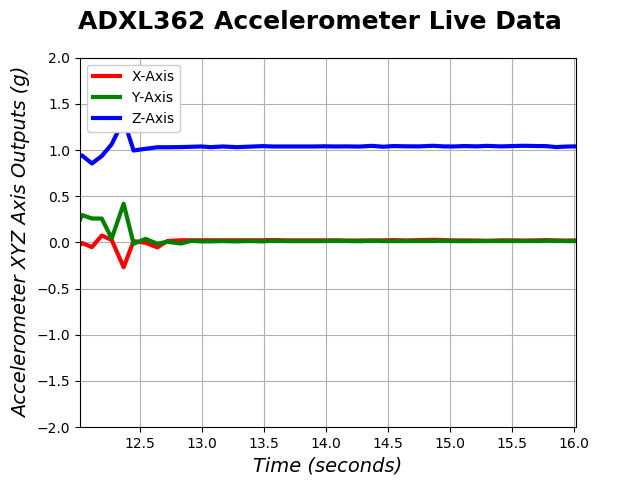

<IPython.core.display.Javascript object>


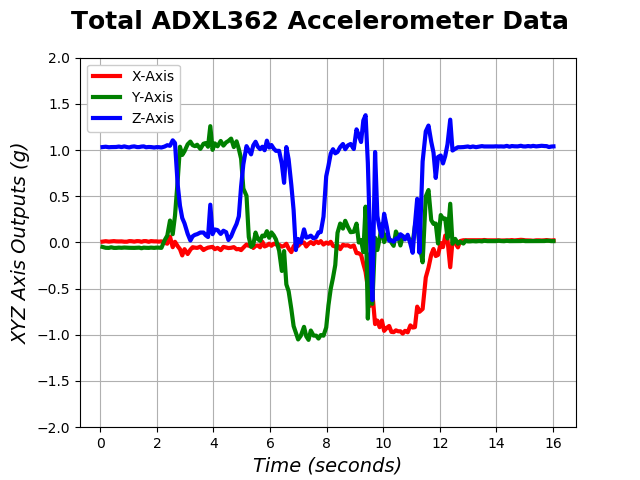

In [1]:
#
# 3- Axis Accelerometer Demo (Plot X,Y,Z)
#
%matplotlib notebook

import serial
import numpy as np
from matplotlib import pyplot as plt
from time import time
#
# Please change here to proper COM port name
#
ser = serial.Serial('COM13', 115200)
#
# ADXL362 register access functions
#
def ADXL362_write_reg(reg, value):
    cmd = "<0a%0.2x%0.2x>" % (reg, value) # Write command 0x0A
    ser.write(bytearray(cmd,'utf8'))  # Send command, REG and value
#
def ADXL362_read_reg8(reg):
    ser.reset_input_buffer()
    cmd = "<0b%0.2x..>" % reg # Read command 0x0B
    ser.write(bytearray(cmd,'utf8'))  # Send command, REG and value
    s = ser.read(2)
    return int(s,16)                  # Convert hex to int
#
def ADXL362_read_reg16(reg):
    ser.reset_input_buffer()
    cmd = "<0b%0.2x..><0b%0.2x..>" % (reg+1, reg) # Read command 0x0B
    ser.write(bytearray(cmd,'utf8'))  # Send command, REG and value
    s = ser.read(4)
    return int(s,16)                 # Convert hex to int
#
# Read sign extended 16 bit register 
#
def ADXL362_read_reg16_sx(reg):
    t = ADXL362_read_reg16(reg)
    if t > 32768: t = t - 65536
    return t    
#    
def ADXL362_read_axis(axis):
    return ADXL362_read_reg16_sx(axis*2 + 0x0e)
#
def ADXL362_read_temperature():
    t = ADXL362_read_reg16_sx(0x14)
    return round((t-350)*0.065+25,2)

ser.write(b'[0]')                # Select UHSA Channel 0 
#
# We need enable measurements!
#
ADXL362_write_reg(0x2d,0x02)     # Enable Measurement Mode 

# Some dummy read first..
ADXL362_read_axis(0)  


#
# Plot functions start here
#
plt.ion() 
start_time = time()
timepoints = []
xdata = []
ydata = []
zdata = []

# yrange = [-1.1,1.1]
yrange = [-2.0, 2.0]
view_time = 4 # seconds of data to view at once
duration = 16 # total seconds to collect data

fig1 = plt.figure()
fig1.suptitle('ADXL362 Accelerometer Live Data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time (seconds)', fontsize='14', fontstyle='italic')
plt.ylabel('Accelerometer XYZ Axis Outputs (g)', fontsize='14', fontstyle='italic')

line1, = plt.plot(timepoints, xdata, color="red", linewidth=3.0)    # RNM 1/03/19 changed line color and thickness
line2, = plt.plot(timepoints, ydata, color="green", linewidth=3.0)     # RNM 1/03/19 changed line color and thickness
line3, = plt.plot(timepoints, zdata, color="blue", linewidth=3.0)   # RNM 1/03/19 changed line color and thickness

plt.legend((line1, line2, line3),          # RNM 01/07/19 added plot legend for all three axes
           ('X-Axis', 'Y-Axis', 'Z-Axis'), 
           loc='upper left',
           framealpha=1.0)

plt.ylim(yrange)
plt.xlim([0,view_time])

ser.flushInput() # Flush junk
ser.reset_input_buffer()


run = True

# collect the data and plot a moving frame
while run:
    # 
    try:
        x = ADXL362_read_axis(0)    
        y = ADXL362_read_axis(1)    
        z = ADXL362_read_axis(2)    
            
        # store the entire dataset for later
#         xdata.append(float(x)*2.0/4096)
#         ydata.append(float(y)*2.0/4096)
#         zdata.append(float(z)*2.0/4096)
        
        xdata.append(float(x)*3.8/4096) # RNM 01/07/19 trimming the scaling to 1g changes for demo
        ydata.append(float(y)*3.8/4096)
        zdata.append(float(z)*3.8/4096)
        
        timepoints.append(time()-start_time)
        current_time = timepoints[-1]
        
        # update the plotted data
        line1.set_xdata(timepoints)
        line1.set_ydata(xdata)

        line2.set_xdata(timepoints)
        line2.set_ydata(ydata)

        line3.set_xdata(timepoints)
        line3.set_ydata(zdata)
        
        # slide the viewing frame along
        if current_time > view_time:
            plt.xlim([current_time-view_time,current_time])
            
        # when time's up, kill the collect+plot loop
        if timepoints[-1] > duration: run=False
    
    # if the try statement throws an error, just do nothing
    except: pass
    
    # update the plot
    fig1.canvas.draw()

# plot all of the data you collected
fig2 = plt.figure()
fig2.suptitle('Total ADXL362 Accelerometer Data', fontsize='18', fontweight='bold')
plt.axes().grid(True)
plt.xlabel('Time (seconds)', fontsize='14', fontstyle='italic')
plt.ylabel('XYZ Axis Outputs (g)', fontsize='14', fontstyle='italic')

plt.plot(timepoints, xdata, color="red", linewidth=3.0)     # RNM 1/03/19 changed line color and thickness
plt.plot(timepoints, ydata, color="green", linewidth=3.0)      # RNM 1/03/19 changed line color and thickness
plt.plot(timepoints, zdata, color="blue", linewidth=3.0)   # RNM 1/03/19 changed line color and thickness

plt.legend((line1, line2, line3),           # RNM 01/07/19 added plot legend for all three axes
           ('X-Axis', 'Y-Axis', 'Z-Axis'), 
           loc='upper left',
           framealpha=1.0)

plt.ylim(yrange)
fig2.show()

ser.close()
